<a name='introduction'></a>
# Проект "Анализ постов на habr.com"

В рамках данного проекта необходимо осуществить парсинг данных с веб-сайта. В качества веб-сайта взят habr.com. Необходимо осуществить парсинг лучших постов за все время. Данные для парсинга: 1) параметры - наименование статьи, дата загрузки, категория, к которой пост относится; количество голосов и 2) целевой показатель - число просмотров. Параметр 'количество голосов' можно также использовать как целевой показатель, поэтому и информация по нему была собрана. Однако в качестве независимого параметра он не подходит, поскольку может сильно зависеть от количества просмотров.

В дальнейшем можно рассмотреть не только лучшие за все время посты, но и увеличить выборку еще б**о**льшим объемом повседневных постов.

Объем выборки составил 997 статей (для 3 не было обнаружено количество просмотров, поэтому от них решено было избавиться. В дополнение, результат работы парсера (база данных) был сохранен в отдельный файл 'posts_data.csv')

<br>**План проекта**:
1. [Импортирование библиотек](#import)
2. [Парсинг данных](#parsing)
3. [Предобработка данных и Feature Engineering](#preprocessing)
    - [Типы данных](#dtypes)
    - [Проверка на аномальные значения](#anomalies)
    - [Feature Engineering](#feature_engineering)
4. [Исследовательский анализ данных](#eda)
    - [Количество постов по годам](#posts_per_year)
    - [Количество постов по категориям](#posts_categories)
    - [Категории постов по годам публикаций](#categories_per_year)

<a name='import'></a>
## 1. Импортирование библиотек

In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import re
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.options import Options
import time

<a name='parsing'></a>
## 2. Парсинг данных
[Вернуться во Введение](#introduction)

Для осуществления парсинга воспользуемся библиотекой selenium. Необходимо получить названия статей, дату их публикации, категории, к которым они относятся, количество голосов и количество просмотров. Для этого будем осуществлять парсинг с помощью бразуера Firefox 50 страниц постов с сайта habr.com по количеству голосов.

In [41]:
firefox_opt = Options()
firefox_opt.page_load_strategy = 'eager'
driver = webdriver.Firefox(options=firefox_opt)

habr_url = 'https://habr.com/ru/top/alltime/'

In [42]:
# Функция для получения данных с одной веб-страницы
def get_page_data(page_num):
    # Заход на веб-страницу
    page_url = f'{habr_url}page{page_num}'
    driver.get(page_url)
    driver.implicitly_wait(5)
    
    # Прокрутка до конца страницы
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    
    # Наименования постов
    titles = [title.text for title in driver.find_elements(By.CLASS_NAME, 'tm-title__link')]
    
    # Количество просмотров
    view_counts_link = driver.find_elements(By.CLASS_NAME, 'tm-icon-counter__value')
    view_counts = []
    for view_count in view_counts_link:
        if 'M' in view_count.text:
            view_counts.append(float(re.split('M', view_count.text)[0]) * 1000)
        elif 'K' in view_count.text:
            view_counts.append(float(re.split('K', view_count.text)[0]))
    
    # Категории
    categories_link = driver.find_elements(By.CLASS_NAME, 'tm-article-snippet__hubs-container')
    categories = []
    for category in categories_link:
        categories.append([i for i in re.split('\n', category.text) if i != '*'])

    # Дата и время публикации
    dates_link = driver.find_elements(By.CSS_SELECTOR, 'time')
    dates = [date.get_attribute('datetime') for date in dates_link if 'в' in date.text]
    
    # Количество голосов
    votes_link = driver.find_elements(By.CLASS_NAME, 'tm-votes-meter.tm-data-icons__item')
    votes = [int(vote.text.split('+')[1]) for vote in votes_link]
    
    # Объединение собранных данных в датафрейм
    df = pd.concat(
        [pd.Series(titles), pd.Series(view_counts), pd.Series(categories), pd.Series(dates), pd.Series(votes)],
        axis=1
    )
    df.columns = ['title', 'view_count', 'category', 'date', 'votes']
    
    return df

In [43]:
# Получим данные с каждой страницы топ-50 по постам
df_posts = pd.DataFrame(columns=['title', 'view_count', 'category', 'date'])

for n in range(1, 51):
    df_posts = df_posts.append(get_page_data(n), ignore_index=True)

driver.quit()

In [45]:
# Получим количество пропущенных значений по каждому столбцу
df_posts.isna().sum()

title         0
view_count    3
category      0
date          0
votes         0
dtype: int64

In [46]:
# Избавимся от постов, для которых не было обнаружено 'view_count' (их всего 3) 
df_posts = df_posts[~df_posts['view_count'].isna()].reset_index(drop=True)
df_posts.head()

,title,view_count,category,date,votes
0,Делаем приватный монитор из старого LCD монитора,958.0,[DIY или Сделай сам],2011-11-27T19:21:13.000Z,1448.0
1,Самый беззащитный — уже не Сапсан. Всё оказало...,524.0,"[Информационная безопасность, Системное админи...",2021-01-13T05:51:41.000Z,1447.0
2,Были получены исходники 3300 глобальных интерн...,268.0,[Информационная безопасность],2009-09-23T09:17:27.000Z,1154.0
3,История игрушки. Поле Чудес,290.0,"[История IT, Игры и игровые консоли]",2011-07-18T08:23:11.000Z,913.0
4,"[Обновлено в 10:52, 14.12.19] В офисе Nginx пр...",311.0,"[Блог компании ITSumma, Nginx, Законодательств...",2019-12-12T12:34:52.000Z,791.0


In [47]:
# Сохраним базу данных в отдельный файл 'posts_data.csv'
df_posts.to_csv('posts_data.csv')

<a name='preprocessing'></a>
## 3. Предобработка данных и Feature Enginnering
[Вернуться во Введение](#introduction)

Рассмотрим типы данных каждого из столбца и, в случае необходимости, поменяем их.

<a name='dtypes'></a>
### 3. 1. Типы данных

In [57]:
df_posts.dtypes

title          object
view_count    float64
category       object
date           object
votes         float64
dtype: object

Можно заметить, что у параметра 'date' тип данных - object, а необходим datatime. Исправим это, поменяв на нужный тип данных. Это позволит создать дополнительные параметры отдельно по году, месяцу, дню, часу и минуте публикации.

In [58]:
df_posts['date'] = pd.to_datetime(df_posts['date'])
df_posts['date'].head()

0   2011-11-27 19:21:13+00:00
1   2021-01-13 05:51:41+00:00
2   2009-09-23 09:17:27+00:00
3   2011-07-18 08:23:11+00:00
4   2019-12-12 12:34:52+00:00
Name: date, dtype: datetime64[ns, UTC]

<a name='anomalies'></a>
### 3. 2. Проверка на аномальные значения 

<a name='feature_engineering'></a>
### 3. 3. Feature Engineering

In [59]:
# Создадим отдельные переменные с годом, месяцем, днем, часом и минутой публикации
df_posts['year'] = df_posts['date'].dt.year
df_posts['month'] = df_posts['date'].dt.month
df_posts['day'] = df_posts['date'].dt.day
df_posts['hour'] = df_posts['date'].dt.hour
df_posts['minute'] = df_posts['date'].dt.minute

df_posts = df_posts.drop('date', axis=1)

In [72]:
# Проверим типы данных и количество пропущенных значений
print("Типы данных:")
display(df_posts.dtypes)

print("Пропущенные значения:")
display(df_posts.isna().sum())

Типы данных:


title          object
view_count    float64
category       object
votes         float64
year            int64
month           int64
day             int64
hour            int64
minute          int64
dtype: object

Пропущенные значения:


title         0
view_count    0
category      0
votes         0
year          0
month         0
day           0
hour          0
minute        0
dtype: int64

In [73]:
df_posts.head()

,title,view_count,category,votes,year,month,day,hour,minute
0,Делаем приватный монитор из старого LCD монитора,958.0,[DIY или Сделай сам],1448.0,2011,11,27,19,21
1,Самый беззащитный — уже не Сапсан. Всё оказало...,524.0,"[Информационная безопасность, Системное админи...",1447.0,2021,1,13,5,51
2,Были получены исходники 3300 глобальных интерн...,268.0,[Информационная безопасность],1154.0,2009,9,23,9,17
3,История игрушки. Поле Чудес,290.0,"[История IT, Игры и игровые консоли]",913.0,2011,7,18,8,23
4,"[Обновлено в 10:52, 14.12.19] В офисе Nginx пр...",311.0,"[Блог компании ITSumma, Nginx, Законодательств...",791.0,2019,12,12,12,34


<a name='eda'></a>
## 4. Исследовательский анализ данных
[Вернуться во Введение](#introduction)

Осуществим исследовательский анализ данных. Рассмотрим следующее:
- [Количество постов по годам](#posts_per_year)
- [Количество постов по категориям](#posts_categories)
- [Категории постов по годам публикаций](#categories_per_year);
- датой публикации и количеством просмотров (год, месяц, день, час и минута);

In [255]:
# Определим необходимые размеры для текста графиков
LABEL_FONTSIZE = 14
TICK_FONTSIZE = 13
TITLE_FONTSIZE = 16

<a name='posts_per_year'></a>
### 4. 1. Количество постов по годам

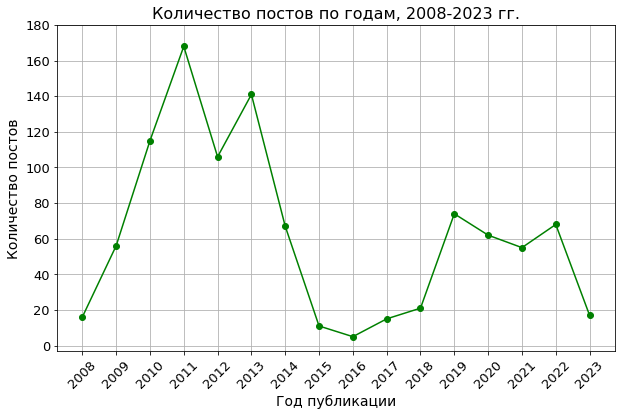

In [256]:
posts_per_year = df_posts.pivot_table(index='year', values='title', aggfunc='count').reset_index()
posts_per_year.columns = ['year', 'count']

plt.figure(figsize=(10,6))

plt.plot(
    posts_per_year['year'],
    posts_per_year['count'],
    '-o',
    color='green',
)

plt.grid()
plt.title('Количество постов по годам, 2008-2023 гг.', fontsize=TITLE_FONTSIZE)
plt.xlabel('Год публикации', fontsize=LABEL_FONTSIZE)
plt.xticks(range(2008, 2024), rotation=45, fontsize=TICK_FONTSIZE)
plt.ylabel('Количество постов', fontsize=LABEL_FONTSIZE)
plt.yticks(range(0, 181, 20), fontsize=TICK_FONTSIZE)
plt.show()

Наибольшее число постов приходится на период с 2010-2013 гг., в то время как в период с 2015 по 2018 гг. наблюдается снижение количества постов, которые находятся в топе по количеству голосов. Возможно, это связано с общим снижением количества публикуемых постов, однако данная гипотеза не может быть ни подтверждена, ни опровергнута ввиду недостатка информации (поиск информации в открытых источниках о количество постов по годам оказался безрезультатным)

<a name='posts_categories'></a>
### 4. 2. Количество постов по категориям

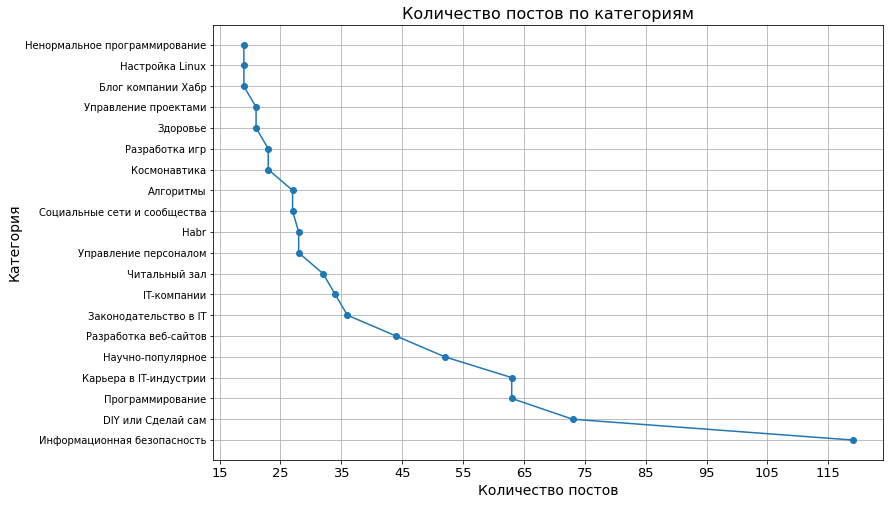

In [258]:
# Отобразим на графике количество 20-и самых популярных по количеству постов категорий
categories_count = df_posts['category'].explode().value_counts().reset_index()
categories_count.columns = ['category', 'count']

plt.figure(figsize=(12, 8))

plt.plot(
    categories_count['count'][:20],
    categories_count['category'][:20],
    '-o'
)

plt.grid()
plt.title('Количество постов по категориям', fontsize=TITLE_FONTSIZE)
plt.xlabel('Количество постов', fontsize=LABEL_FONTSIZE)
plt.xticks(range(15, 121, 10), fontsize=TICK_FONTSIZE)
plt.ylabel('Категория', fontsize=LABEL_FONTSIZE)
plt.show()

Примечательно, что наибольшую популярность представляют собой "общие" категории, которые не относятся к отдельному блогу определенной компании (кроме Habr). В топ-5 категорий по количеству постов входят:
1. Информационная безопасность;
2. DIY или Сделай сам;
3. Программирование;
4. Карьера в IT-индустрии;
5. Научно-популярное.

Более того, данные категории не являются узкоспециализированными, чем и объясняется их популярность не только со стороны авторов постов, но и со стороны их читателей.

<a name='categories_per_year'></a>
### 4. 3. Категории постов по годам публикаций

In [284]:
#  Получим количество постов по категориям по годам публикаций
categories_per_year = {}
for i in range(2008, 2024):
    category_per_year = df_posts[df_posts['year'] == i]['category'].explode().value_counts().reset_index()
    category_per_year.columns = ['category', 'count']
    categories_per_year[i] = category_per_year

categories_per_year_df = pd.DataFrame({
        (outerKey, innerKey): values \
        for outerKey, innerDict in categories_per_year.items() \
        for innerKey, values in innerDict.items()
})

# Получим 20 самых распространенных по количеству постов категорий за каждый год
categories_per_year_df[:20]

2008                                2009        \
                       category count                      category count   
0                 Читальный зал   2.0   Информационная безопасность   8.0   
1       Блог компании Parallels   1.0                        Дизайн   4.0   
2           Компьютерное железо   1.0                           GTD   3.0   
3              Программирование   1.0             Научно-популярное   3.0   
4                 Google Chrome   1.0                       Хостинг   2.0   
5           Антивирусная защита   1.0           Компьютерное железо   2.0   
6                          Habr   1.0                   Мессенджеры   2.0   
7                   Типографика   1.0          Учебный процесс в IT   2.0   
8                    Интерфейсы   1.0  Социальные сети и сообщества   2.0   
9   Информационная безопасность   1.0         Разработка веб-сайтов   2.0   
10                 Краудсорсинг   1.0               Биографии гиков   2.0   
11                     Копирайт   1.0                       Фриланс   2.0   
12                    Смартфоны   1.0         Серверная оптимизация   2.0   
13                       Дизайн   1.0              Программирование   2.0   
14                         Софт   1.0                     Assembler   1.0   
15                          NaN   NaN                 Биотехнологии   1.0   
16                          NaN   NaN        Управление сообществом   1.0   
17                          NaN   NaN               Настройка Linux   1.0   
18                          NaN   NaN                 Будущее здесь   1.0   
19                          NaN   NaN                     Периферия   1.0   

                             2010                                 2011        \
                         category count                       category count   
0     Информационная безопасность  12.0             DIY или Сделай сам  21.0   
1              DIY или Сделай сам  11.0    Информационная безопасность  18.0   
2           Разработка веб-сайтов   8.0   Социальные сети и сообщества   9.0   
3    Социальные сети и сообщества   6.0               Программирование   7.0   
4                     IT-компании   6.0                      Алгоритмы   7.0   
5          Разработка под Windows   5.0         Карьера в IT-индустрии   6.0   
6                        Копирайт   5.0                       Копирайт   6.0   
7                             GTD   4.0                         Дизайн   5.0   
8                          Дизайн   4.0                Настройка Linux   5.0   
9             Компьютерное железо   3.0     Электроника для начинающих   5.0   
10          Законодательство в IT   3.0                            CSS   5.0   
11              Офисы IT-компаний   3.0          Разработка веб-сайтов   5.0   
12                Настройка Linux   3.0                            GTD   5.0   
13                     Интерфейсы   3.0                    IT-компании   4.0   
14             Лайфхаки для гиков   2.0                     Интерфейсы   4.0   
15           Управление продажами   2.0              Научно-популярное   4.0   
16  Ненормальное программирование   2.0  Ненормальное программирование   4.0   
17                      Алгоритмы   2.0                            C++   3.0   
18          Управление e-commerce   2.0          Законодательство в IT   3.0   
19                        Хостинг   2.0    Системное администрирование   3.0   

                           2012        ...  \
                       category count  ...   
0   Информационная безопасность  10.0  ...   
1              Программирование   8.0  ...   
2         Разработка веб-сайтов   6.0  ...   
3    Электроника для начинающих   6.0  ...   
4                 Робототехника   6.0  ...   
5         Законодательство в IT   5.0  ...   
6             Научно-популярное   5.0  ...   
7                     Алгоритмы   4.0  ...   
8                Разработка игр   4.0  ...   
9            DIY или Сделай сам   4.0  ...   
10                 

https://stackoverflow.com/questions/25386870/pandas-plotting-with-multi-index

In [286]:
ax = categories_per_year_df.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(2, 3))
plt.tight_layout()

TypeError: no numeric data to plot

In [276]:
pd.DataFrame(reform)

2008                                2009        \
                       category count                      category count   
0                 Читальный зал   2.0   Информационная безопасность     8   
1       Блог компании Parallels   1.0                        Дизайн     4   
2           Компьютерное железо   1.0                           GTD     3   
3              Программирование   1.0             Научно-популярное     3   
4                 Google Chrome   1.0                       Хостинг     2   
5           Антивирусная защита   1.0           Компьютерное железо     2   
6                          Habr   1.0                   Мессенджеры     2   
7                   Типографика   1.0          Учебный процесс в IT     2   
8                    Интерфейсы   1.0  Социальные сети и сообщества     2   
9   Информационная безопасность   1.0         Разработка веб-сайтов     2   
10                 Краудсорсинг   1.0               Биографии гиков     2   
11                     Копирайт   1.0                       Фриланс     2   
12                    Смартфоны   1.0         Серверная оптимизация     2   
13                       Дизайн   1.0              Программирование     2   
14                         Софт   1.0                     Assembler     1   
15                          NaN   NaN                 Биотехнологии     1   
16                          NaN   NaN        Управление сообществом     1   
17                          NaN   NaN               Настройка Linux     1   
18                          NaN   NaN                 Будущее здесь     1   
19                          NaN   NaN                     Периферия     1   

                             2010                                 2011        \
                         category count                       category count   
0     Информационная безопасность    12             DIY или Сделай сам    21   
1              DIY или Сделай сам    11    Информационная безопасность    18   
2           Разработка веб-сайтов     8   Социальные сети и сообщества     9   
3    Социальные сети и сообщества     6               Программирование     7   
4                     IT-компании     6                      Алгоритмы     7   
5          Разработка под Windows     5         Карьера в IT-индустрии     6   
6                        Копирайт     5                       Копирайт     6   
7                             GTD     4                         Дизайн     5   
8                          Дизайн     4                Настройка Linux     5   
9             Компьютерное железо     3     Электроника для начинающих     5   
10          Законодательство в IT     3                            CSS     5   
11              Офисы IT-компаний     3          Разработка веб-сайтов     5   
12                Настройка Linux     3                            GTD     5   
13                     Интерфейсы     3                    IT-компании     4   
14             Лайфхаки для гиков     2                     Интерфейсы     4   
15           Управление продажами     2              Научно-популярное     4   
16  Ненормальное программирование     2  Ненормальное программирование     4   
17                      Алгоритмы     2                            C++     3   
18          Управление e-commerce     2          Законодательство в IT     3   
19                        Хостинг     2    Системное администрирование     3   

                           2012        ...  \
                       category count  ...   
0   Информационная безопасность    10  ...   
1              Программирование     8  ...   
2         Разработка веб-сайтов     6  ...   
3    Электроника для начинающих     6  ...   
4                 Робототехника     6  ...   
5         Законодательство в IT     5  ...   
6             Научно-популярное     5  ...   
7                     Алгоритмы     4  ...   
8                Разработка игр     4  ...   
9            DIY или Сделай сам     4  ...   
10                 

In [277]:
reform

2008                                2009        \
                       category count                      category count   
0                 Читальный зал   2.0   Информационная безопасность     8   
1       Блог компании Parallels   1.0                        Дизайн     4   
2           Компьютерное железо   1.0                           GTD     3   
3              Программирование   1.0             Научно-популярное     3   
4                 Google Chrome   1.0                       Хостинг     2   
5           Антивирусная защита   1.0           Компьютерное железо     2   
6                          Habr   1.0                   Мессенджеры     2   
7                   Типографика   1.0          Учебный процесс в IT     2   
8                    Интерфейсы   1.0  Социальные сети и сообщества     2   
9   Информационная безопасность   1.0         Разработка веб-сайтов     2   
10                 Краудсорсинг   1.0               Биографии гиков     2   
11                     Копирайт   1.0                       Фриланс     2   
12                    Смартфоны   1.0         Серверная оптимизация     2   
13                       Дизайн   1.0              Программирование     2   
14                         Софт   1.0                     Assembler     1   
15                          NaN   NaN                 Биотехнологии     1   
16                          NaN   NaN        Управление сообществом     1   
17                          NaN   NaN               Настройка Linux     1   
18                          NaN   NaN                 Будущее здесь     1   
19                          NaN   NaN                     Периферия     1   

                             2010                                 2011        \
                         category count                       category count   
0     Информационная безопасность    12             DIY или Сделай сам    21   
1              DIY или Сделай сам    11    Информационная безопасность    18   
2           Разработка веб-сайтов     8   Социальные сети и сообщества     9   
3    Социальные сети и сообщества     6               Программирование     7   
4                     IT-компании     6                      Алгоритмы     7   
5          Разработка под Windows     5         Карьера в IT-индустрии     6   
6                        Копирайт     5                       Копирайт     6   
7                             GTD     4                         Дизайн     5   
8                          Дизайн     4                Настройка Linux     5   
9             Компьютерное железо     3     Электроника для начинающих     5   
10          Законодательство в IT     3                            CSS     5   
11              Офисы IT-компаний     3          Разработка веб-сайтов     5   
12                Настройка Linux     3                            GTD     5   
13                     Интерфейсы     3                    IT-компании     4   
14             Лайфхаки для гиков     2                     Интерфейсы     4   
15           Управление продажами     2              Научно-популярное     4   
16  Ненормальное программирование     2  Ненормальное программирование     4   
17                      Алгоритмы     2                            C++     3   
18          Управление e-commerce     2          Законодательство в IT     3   
19                        Хостинг     2    Системное администрирование     3   

                           2012        ...  \
                       category count  ...   
0   Информационная безопасность    10  ...   
1              Программирование     8  ...   
2         Разработка веб-сайтов     6  ...   
3    Электроника для начинающих     6  ...   
4                 Робототехника     6  ...   
5         Законодательство в IT     5  ...   
6             Научно-популярное     5  ...   
7                     Алгоритмы     4  ...   
8                Разработка игр     4  ...   
9            DIY или Сделай сам     4  ...   
10                 

### 4. ??? Корреляция phik

interval columns not set, guessing: ['view_count', 'votes', 'year', 'month', 'day', 'hour', 'minute']


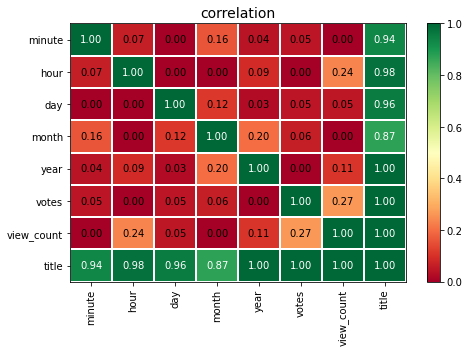

In [261]:
import phik
from phik.report import plot_correlation_matrix
from phik import report


df_posts_test = df_posts.drop('category', axis=1)

phik_overview = df_posts_test.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1
)

NameError: name 'view_count' is not defined